In [1]:
!pip install git+https://github.com/xju2/root_gnn.git@release2.0

  Cloning https://github.com/xju2/root_gnn.git (to revision release2.0) to /tmp/pip-req-build-xyavfmkn
  Using cached https://github.com/deepmind/graph_nets/tarball/master
  Created wheel for root-gnn: filename=root_gnn-2.0.0-py3-none-any.whl size=136782 sha256=edf50f583c7e22dae3848616f885c5720afd255a5185b26663400cf63a5a5433
  Stored in directory: /tmp/pip-ephem-wheel-cache-mjwnnzf3/wheels/24/c2/ad/75e66516ceff219f24d763f97a0928597e0f867e260d65aac5
Successfully built root-gnn
  Attempting uninstall: root-gnn
    Found existing installation: root-gnn 1.0.0
    Uninstalling root-gnn-1.0.0:
      Successfully uninstalled root-gnn-1.0.0


### Creating graphs from networkx

[networkx](https://networkx.org/documentation/stable/tutorial.html) is a Python package for the study of graphs.


In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets import graphs as Graphs

In [3]:
g = nx.DiGraph()

# add nodes
[g.add_node(idx, features=np.array([1.*idx])) for idx in range(4)];

# add edges
edge_lists = [(0, 1), (1, 2), (2, 3), (3, 0)]
[g.add_edge(i, j, features=np.array([abs(i-j)])) for i,j in edge_lists];

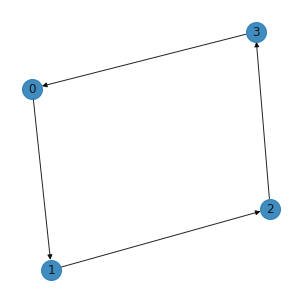

In [4]:
plt.figure(figsize=(4, 4))
pos = nx.spring_layout(g)
nx.draw(g, pos, node_size=400, alpha=0.85, node_color="#1f78b4", with_labels=True)

obtain the adjacency matrix

In [5]:
adj = np.asarray(nx.to_numpy_matrix(g))
adj

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [6]:
g.edges()

OutEdgeView([(0, 1), (1, 2), (2, 3), (3, 0)])

In [7]:
g_tuple = utils_np.networkxs_to_graphs_tuple([g])

In [8]:
g_tuple

GraphsTuple(nodes=array([[0.],
       [1.],
       [2.],
       [3.]]), edges=array([[1],
       [1],
       [1],
       [3]]), receivers=array([1, 2, 3, 0], dtype=int32), senders=array([0, 1, 2, 3], dtype=int32), globals=None, n_node=array([4], dtype=int32), n_edge=array([4], dtype=int32))

In [33]:
def print_graphs_tuple(g, data=True):
    for field_name in Graphs.ALL_FIELDS:
        per_replica_sample = getattr(g, field_name)
        if per_replica_sample is None:
            print(field_name, "EMPTY")
        else:
            print(field_name, "is with shape", per_replica_sample.shape)
            if data and  field_name != "edges":
                print(per_replica_sample)

In [34]:
print_graphs_tuple(g_tuple)

nodes is with shape (4, 1)
[[0.]
 [1.]
 [2.]
 [3.]]
edges is with shape (4, 1)
receivers is with shape (4,)
[1 2 3 0]
senders is with shape (4,)
[0 1 2 3]
globals EMPTY
n_node is with shape (1,)
[4]
n_edge is with shape (1,)
[4]


### Create GraphsTuple using data-dict \[recommend\]

In [11]:
n_node = 4
n_node_features = 1
n_edge = 4
n_edge_features = 1
nodes = np.random.rand(n_node, n_node_features).astype(np.float32)
edges = np.random.rand(n_edge, n_edge_features).astype(np.float32)
receivers = np.array([1, 2, 3, 0])
senders = np.array([0, 1, 2, 3])
datadict = {
    "n_node": n_node,
    "n_edge": n_edge,
    "nodes": nodes,
    "edges": edges,
    "senders": senders,
    "receivers": receivers,
    "globals": np.array([0], dtype=np.float32)
}

In [12]:
g_tuple2 = utils_tf.data_dicts_to_graphs_tuple([datadict])

In [13]:
print_graphs_tuple(g_tuple2)

nodes is with shape (4, 1)
tf.Tensor(
[[0.23445006]
 [0.8710079 ]
 [0.03835069]
 [0.2980138 ]], shape=(4, 1), dtype=float32)
edges is with shape (4, 1)
receivers is with shape (4,)
tf.Tensor([1 2 3 0], shape=(4,), dtype=int32)
senders is with shape (4,)
tf.Tensor([0 1 2 3], shape=(4,), dtype=int32)
globals is with shape (1, 1)
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
n_node is with shape (1,)
tf.Tensor([4], shape=(1,), dtype=int32)
n_edge is with shape (1,)
tf.Tensor([4], shape=(1,), dtype=int32)


### Convert an event to a fully-connected graph

In [14]:
filename = '/global/homes/x/xju/atlas/data/top-tagger/test.h5'

In [15]:
with pd.HDFStore(filename, mode='r') as store:
    df = store['table']

In [16]:
df.head()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,E_199,PX_199,PY_199,PZ_199,truthE,truthPX,truthPY,truthPZ,ttv,is_signal_new
436,218.364243,-172.341858,110.129105,-76.503624,153.661118,-111.320465,93.167969,-50.390713,76.708054,-56.523701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
440,122.238762,26.738468,-91.613998,76.382225,121.227135,17.644758,-93.015450,75.715302,90.420105,21.377417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
441,383.772308,-97.906456,79.640709,-362.426361,200.625992,-54.921326,37.994343,-189.184753,123.247223,-33.828953,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
444,132.492752,-77.763947,-87.322601,-62.304600,83.946594,-49.450481,-53.823605,-41.288010,28.072624,-19.964916,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
445,730.786987,-209.120010,-193.454315,-672.973877,225.477325,-75.363350,-66.226990,-201.926651,217.040192,-63.698189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [17]:
df[df['is_signal_new'] == 1].head()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,E_199,PX_199,PY_199,PZ_199,truthE,truthPX,truthPY,truthPZ,ttv,is_signal_new
275,65.646370,-58.526817,29.698223,-1.439855,64.047226,-36.257854,46.957092,24.133938,46.889977,-26.141216,...,0.0,0.0,0.0,0.0,609.978516,-425.223938,360.547333,179.307800,1,1
278,182.433838,-67.388512,-150.770279,77.519150,105.039909,-24.843391,-70.149010,74.130325,99.697556,-25.996574,...,0.0,0.0,0.0,0.0,761.416626,-368.340454,-444.232635,466.554565,1,1
285,218.015808,-142.368179,19.166389,-163.996475,151.196808,-75.772964,7.036884,-130.649979,64.975327,-49.838360,...,0.0,0.0,0.0,0.0,1055.739014,-647.505615,54.828110,-814.257935,1,1
302,116.801796,90.702217,-54.621929,49.317455,87.957840,44.834236,-44.274315,61.369846,66.443222,31.902834,...,0.0,0.0,0.0,0.0,669.998962,439.078888,-269.705780,392.723145,1,1
308,114.989540,-70.048080,-66.881485,-61.989738,74.398933,-57.145046,-44.540745,-16.904631,48.529976,-37.200237,...,0.0,0.0,0.0,0.0,803.532227,-520.018433,-429.099030,-403.125366,1,1


In [18]:
event = df.iloc[0]
event

E_0              218.364243
PX_0            -172.341858
PY_0             110.129105
PZ_0             -76.503624
E_1              153.661118
                    ...    
truthPX            0.000000
truthPY            0.000000
truthPZ            0.000000
ttv                1.000000
is_signal_new      0.000000
Name: 436, Length: 806, dtype: float64

In [35]:
import itertools
from typing import Optional

features = ['E', 'PX', 'PY', 'PZ']
scale = 0.001
solution = 'is_signal_new'

def make_graph(event, debug: Optional[bool] = False):
    n_max_nodes = 200
    n_nodes = 0
    nodes = []
    for inode in range(n_max_nodes):
        E_name = 'E_{}'.format(inode)
        if event[E_name] < 0.1:
            continue

        f_keynames = ['{}_{}'.format(x, inode) for x in features]
        n_nodes += 1
        nodes.append(event[f_keynames].values*scale)
    nodes = np.array(nodes, dtype=np.float32)

    # to make a bi-directional fully connected graph
    all_edges = list(itertools.combinations(range(n_nodes), 2))
    senders = np.array([x[0] for x in all_edges])
    receivers = np.array([x[1] for x in all_edges])
    n_edges = len(all_edges)
    edges = np.expand_dims(np.array([0.0]*n_edges, dtype=np.float32), axis=1)

    input_datadict = {
        "n_node": n_nodes,
        "n_edge": n_edges,
        "nodes": nodes,
        "edges": edges,
        "senders": senders,
        "receivers": receivers,
        "globals": np.array([n_nodes], dtype=np.float32)
    }
    target_datadict = {
        "n_node": n_nodes,
        "n_edge": n_edges,
        "nodes": nodes,
        "edges": edges,
        "senders": senders,
        "receivers": receivers,
        "globals": np.array([event[solution]], dtype=np.float32)
    }
    input_graph = utils_tf.data_dicts_to_graphs_tuple([input_datadict])
    target_graph = utils_tf.data_dicts_to_graphs_tuple([target_datadict])
    return [(input_graph, target_graph)]

In [36]:
graphs = make_graph(event)

In [37]:
g_evt_input, g_evt_target = graphs[0]

In [38]:
print_graphs_tuple(g_evt_input, data=False)

nodes is with shape (17, 4)
edges is with shape (136, 1)
receivers is with shape (136,)
senders is with shape (136,)
globals is with shape (1, 1)
n_node is with shape (1,)
n_edge is with shape (1,)


In [39]:
17*16//2

136

In [40]:
g_evt_target.globals

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>

Convert all events into graphs and save these graphs for training

In [ ]:
def read(filename):
    with pd.HDFStore(filename, mode='r') as store:
        df = store['table']
    
    print("Total {:,} events in file {}".format(df.shape[0], filename))
    for ievt in range(df.shape[0]):
        yield df.iloc[ievt]

In [42]:
from root_gnn.src.datasets.base import DataSet

In [43]:
class TopTaggerDataset(DataSet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.read = read
        self.make_graph = make_graph

    def _num_evts(self, filename):
        with pd.HDFStore(filename, mode='r') as store:
            df = store['table']
        return df.shape[0]

In [44]:
data = TopTaggerDataset()

In [49]:
tr_filename = '/global/homes/x/xju/atlas/data/top-tagger/train.h5'
n_evts_per_record = 10
debug = False
max_evts = 50
num_workers = 1
overwrite = False

In [51]:
data.process(filename=tr_filename, outname="TopTagger/trainning",\
    n_evts_per_record=n_evts_per_record, debug=debug,
    max_evts=max_evts, num_workers=num_workers, overwrite=overwrite)

In total 50 events, write to 5 files with 1 workers
1,211,000 Events


KeyboardInterrupt: 

### 3. Training GNN

In [ ]:
from root_gnn import model as all_models
import sonnet as snt
from root_gnn import losses

In [ ]:
model = all_models.GlobalClassifierNoEdgeInfo()

In [ ]:
num_processing_steps_tr = 10
outputs_tr = model(g_evt_input, num_processing_steps_tr)

In [ ]:
outputs_tr[-1].globals

In [ ]:
g_evt_target.globals

In [ ]:
loss_fcn = losses.GlobalLoss(real_global_weight=1., fake_global_weight=1.)

In [ ]:
loss_fcn(g_evt_target, outputs_tr)

In [ ]:
learning_rate = 0.0005
optimizer = snt.optimizers.Adam(learning_rate)

```python
@functools.partial(tf.function, input_signature=input_signature)
def update_step(inputs_tr, targets_tr):
    print("Tracing update_step")
    with tf.GradientTape() as tape:
        outputs_tr = model(inputs_tr, num_processing_steps_tr)
        loss_ops_tr = loss_fcn(targets_tr, outputs_tr)
        loss_op_tr = tf.math.reduce_sum(loss_ops_tr) / tf.constant(num_processing_steps_tr, dtype=tf.float32)

    gradients = tape.gradient(loss_op_tr, model.trainable_variables)
    optimizer.apply(gradients, model.trainable_variables)
    return outputs_tr, loss_op_tr
```

### 4. Evaluating GNN